In [169]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import numpy as np
import logging
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import subprocess

In [143]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


### Path

In [144]:
main_dir = r"D:\1 Main File\Project File\Capstone Bangkit\MakeDataset6"
dataset_dir = os.path.join(main_dir, 'dataset')
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')
log_path = os.path.join(main_dir, 'training_log.txt')
model_path = os.path.join(main_dir, 'newmodel.h5')
os.makedirs(main_dir, exist_ok=True)
os.makedirs(main_dir, exist_ok=True)

### Preprocessing

In [145]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

In [146]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 21528 images belonging to 6 classes.
Found 4770 images belonging to 6 classes.
Found 1428 images belonging to 6 classes.


### Load ResNet50

In [147]:
# Load pretrained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

### Custom Layers and fine-tuning

In [148]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

### Build model

In [149]:
model = Model(inputs=base_model.input, outputs=predictions)

### Training callback

In [150]:
import tensorflow as tf

class MonitorTraining(tf.keras.callbacks.Callback):
    def __init__(self, patience=3, overfit_gap=0.2, underfit_threshold=1.0):
        super(MonitorTraining, self).__init__()
        self.patience = patience
        self.overfit_gap = overfit_gap
        self.underfit_threshold = underfit_threshold
        self.wait = 0
        self.best_val_loss = float('inf')
        self.reason = None
        self.previous_train_loss = float('inf')  # Menyimpan loss dari epoch sebelumnya

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        # underfit
        if train_loss > self.underfit_threshold:
            self.reason = (
                f"\nTraining is stopped due to underfit at epoch {epoch}. \n"
                f"Train_loss: {train_loss:.4f} > Underfit threshold: {self.underfit_threshold:.4f}")
            print(self.reason)
            self.model.stop_training = True
            return

        # overfit
        loss_gap = abs(val_loss - train_loss)
        if loss_gap > self.overfit_gap:
            self.wait += 1
            if self.wait >= self.patience:
                self.reason = (
                    f"\nTraining is stopped due to overfit at epoch {epoch}.\n"
                    f"Loss gap: {loss_gap:.4f} > Overfit gap: {self.overfit_gap:.4f}\n"
                    f"For {self.patience} consecutive epochs."
                )
                print(self.reason)
                self.model.stop_training = True
        else:
            # Reset counter
            self.wait = 0
            self.best_val_loss = min(self.best_val_loss, val_loss)

        # Stop training if current train loss is worse than previous
        if train_loss > self.previous_train_loss:
            self.reason = (
                f"\nTraining is stopped because the training loss increased at epoch {epoch}.\n"
                f"Current Train Loss: {train_loss:.4f} > Previous Train Loss: {self.previous_train_loss:.4f}"
            )
            print(self.reason)
            self.model.stop_training = True

        # Update previous train loss
        self.previous_train_loss = train_loss

    def on_train_end(self, logs=None):
        # best fit
        if self.reason is None:
            print("\nTraining is completed without overfit or underfit detection.")

In [151]:
class MonitorBestEpoch(tf.keras.callbacks.Callback):
    def __init__(self):
        super(MonitorBestEpoch, self).__init__()
        self.best_epoch = 0
        self.min_mse_loss = float('inf')
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        # Ambil nilai loss dan val_loss
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        # Hitung MSE untuk loss dan val_loss
        mse_loss = np.square(train_loss - val_loss)

        # Simpan epoch terbaik jika MSE lebih kecil
        if mse_loss < self.min_mse_loss:
            self.min_mse_loss = mse_loss
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()  # Simpan bobot model
            print(f"New best MSE loss: {mse_loss:.4f} at epoch {epoch + 1}")

    def on_train_end(self, logs=None):
        # Set bobot model ke epoch terbaik
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"Model weights set to best epoch: {self.best_epoch + 1} with MSE loss: {self.min_mse_loss:.4f}")

In [152]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [153]:
# Callback MonitorTraining
monitor_training = MonitorTraining(
    patience=5,
    overfit_gap=0.3,
    underfit_threshold=1.0
)

In [154]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [155]:
logging.basicConfig(filename=log_path, level=logging.INFO)

In [156]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

Epoch 1/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 3932s 6s/step - accuracy: 0.2685 - loss: 2.1177 - val_accuracy: 0.3700 - val_loss: 1.6392 - learning_rate: 1.0000e-05
Epoch 2/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 4296s 6s/step - accuracy: 0.6647 - loss: 0.9218 - val_accuracy: 0.8419 - val_loss: 0.4891 - learning_rate: 1.0000e-05
Epoch 3/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 4733s 7s/step - accuracy: 0.8443 - loss: 0.4702 - val_accuracy: 0.8878 - val_loss: 0.3623 - learning_rate: 1.0000e-05
Epoch 4/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 3855s 6s/step - accuracy: 0.9211 - loss: 0.2647 - val_accuracy: 0.8914 - val_loss: 0.3250 - learning_rate: 1.0000e-05
Epoch 5/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 3809s 6s/step - accuracy: 0.9575 - loss: 0.1534 - val_accuracy: 0.8885 - val_loss: 0.3407 - learning_rate: 1.0000e-05
Epoch 6/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 3814s 6s/step - accuracy: 0.9766 - loss: 0.0989 - val_accuracy: 0.8927 - val_loss: 0.3374 - learning_rate: 1.0000e-05
Epoch 7/10
673/673 ━━━━━━━━━━━━━━━━━━━━ 3806s 6s/ste

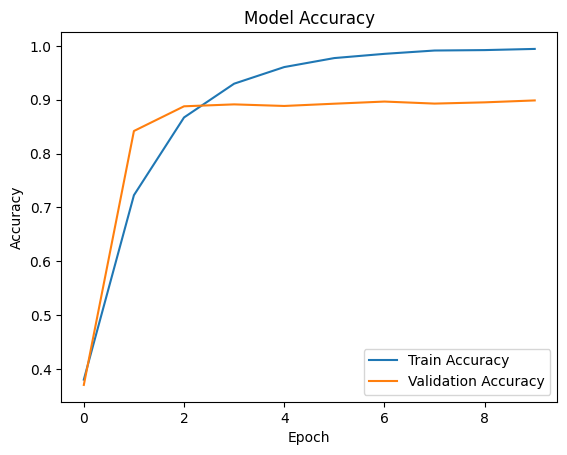

In [157]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

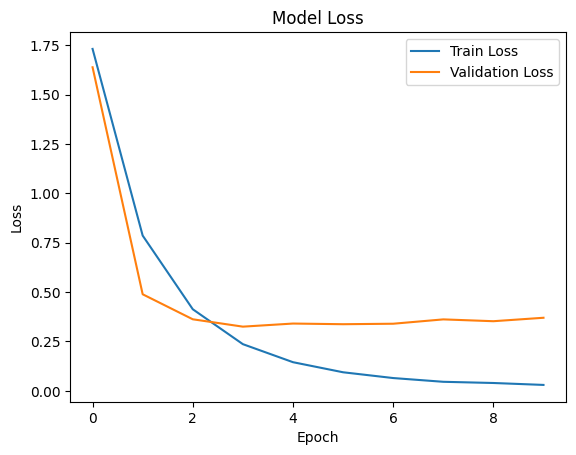

In [158]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [159]:
model.save(model_path)
print(f"Model saved as {model_path}")

Model saved as D:\1 Main File\Project File\Capstone Bangkit\MakeDataset6\newmodel.h5


In [160]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9050 - loss: 0.3377
Test Loss: 0.2599, Test Accuracy: 0.9286


In [161]:
prediction = model.predict(test_generator)
predicted_class_indices = tf.argmax(prediction, axis=1)

45/45 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step


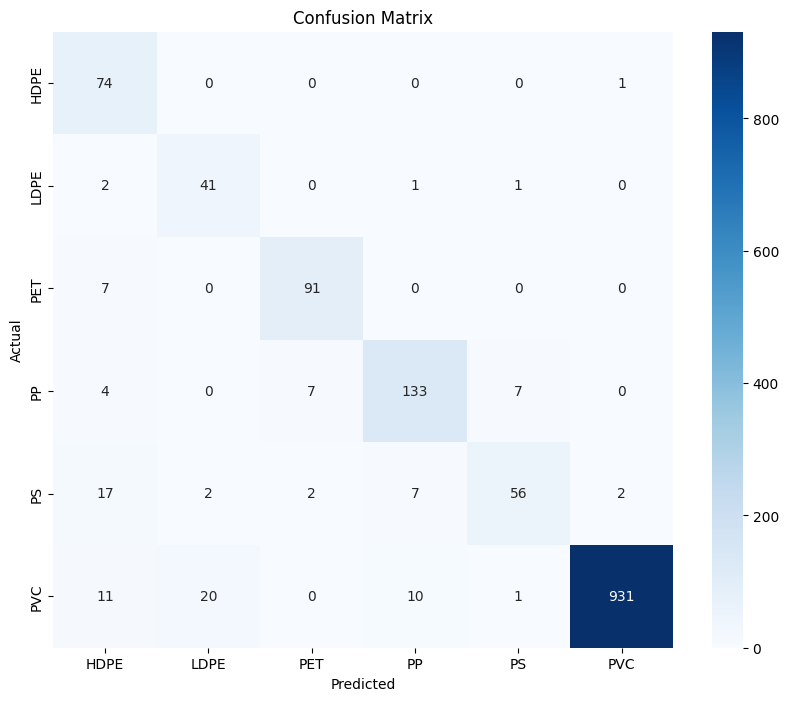

In [162]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [163]:
report = classification_report(true_classes, predicted_class_indices, target_names=class_labels)
print(report)
logging.info("Test Loss: %.4f, Test Accuracy: %.4f".format(test_loss, test_acc))
logging.info("Classification Report: \n{}" + report)

              precision    recall  f1-score   support

        HDPE       0.64      0.99      0.78        75
        LDPE       0.65      0.91      0.76        45
         PET       0.91      0.93      0.92        98
          PP       0.88      0.88      0.88       151
          PS       0.86      0.65      0.74        86
         PVC       1.00      0.96      0.98       973

    accuracy                           0.93      1428
   macro avg       0.82      0.89      0.84      1428
weighted avg       0.94      0.93      0.93      1428



In [ ]:
def create_requirements_file():
    folder_path = r"D:\1 Main File\Project File\Capstone Bangkit\model6class"
    requirements_file_path = os.path.join(folder_path, 'requirements.txt')

    os.makedirs(folder_path, exist_ok=True)

    try:
        with open(requirements_file_path, 'w') as f:
            subprocess.run(['pip', 'freeze'], stdout=f, stderr=subprocess.PIPE)
        print(f"requirements.txt has been created at {requirements_file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

create_requirements_file()

requirements.txt has been created at D:\1 Main File\Project File\Capstone Bangkit\model6class\requirements.txt
